# HackGTeeny AI Workshop

This is a Colaboratory notebook. Notebooks like this are often used in data science and machine learning because they provide a unified environment for code, text, and charts. 


**If you want to edit or interact with this notebook, use the `playground` button!**


---

# Topics

- Natural Language Processing (NLP) on old HackGT 4 submissions


## Setup

Cells can contain code or text. You can run a code by clicking the run button to the left or by pressing shift-enter.

Try running the cell below to make sure everything is working (make sure you've entered playground mode)

In [25]:
print("Hello world!")

Hello world!


Colaboratory has a lot of useful libraries installed automatically. Below are some standard imports that you'll see in nearly every single ML project.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.0: Pandas!
![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/218px-Grosser_Panda.JPG)
  

---




- `pandas` is a staple library for machine learning and data science 
- Think of it as a **very** fast csv wrapper
  - sql style operations
  - charts
  - makes life easier by replacing lots of for loops


The main abstraction is a `DataFrame`, often as a variable called `df`.  
  
  When I say dataframe, think table.
  
  Most of the operations are pretty self explanatory. 
  
  Below, we'll read a CSV file that I've prepared containing submissions from HackGT last year. 
  

In [27]:
# this can also be a local (to the cloud instance) file!
location = 'https://gist.githubusercontent.com/ruyimarone/04d356038138f12df205da9934e797f1/raw/e3bb9212eae46e10f85b765f5a3ab95e0428c3ee/data.csv'
df = pd.read_csv(location)
# this drops any rows that have NaN values or other missing entries - we won't worry about them
df = df.dropna()

We can check the contents of a `DataFrame` by inspecting the first few rows:

In [28]:
df.head()

,submission,description,tags
0,Cinema4All,Inspiration\n\nWhen exploring different proble...,"azure, react, heroku, css, javascript"
1,helpr,Inspiration\n\nWhen considering the types of u...,"love, caffeine, android-studio, arduino, iot, ..."
2,Book Match: Vocabing,Inspiration\n\nGRE Test Prep\n\nWhat it does\n...,"python, mysql, azure, nltk, natural-language-p..."
3,Parking sensor,"Inspiration\n\nOne day, while driving, Sarah b...","arduino, pwm"
4,HackGTOne,Inspiration\n\nWe wanted to improve the custom...,"java, android"


We can also do advanced selections. For example, if we wanted every project that was tagged on devpost with python:

In [29]:
df[df.tags.str.contains('python') & df.tags.str.contains('pandas')].head()

,submission,description,tags
7,Airline Delays Visualization,Inspiration\n\nI love airplanes and big data i...,"pandas, numpy, python, jupyter-notebook"
92,Huber,Huber\n\nHuber is new. It's different. All you...,"typescript, jupyter-notebook, python, javascri..."
135,InvestFolio,Inspiration\n\nEasy to use. Free. \n\nWhat it ...,"php, google-cloud, scikit-learn, python, mysql..."


Let's compare some libraries and languages:

In [30]:
df[df['tags'].str.contains('python')].tags.count()

66

In [31]:
df[df['tags'].str.contains('node.js')].tags.count()

30

In [32]:
#TOOD should thie be here?

############
#Challenge!#
############


#if you are bored, use this cell to create a histogram/bar chart of tags
#use pandas and matplotlib as concisely and clearly as possible

## 2.0 NLP: Clustering Words


---

Back to the slides!





### 2.1 Getting Terms and Documents

Imports and boilerplate...

In [33]:
#also super common 
import nltk #natural language toolkit
import sklearn #python library for classical machine learning 

`CountVectorizer` : generates bag of word vectors

In [34]:
cv = sklearn.feature_extraction.text.CountVectorizer()
m = cv.fit_transform(['this is a document', 'this is a second document', 'third document document document']).todense()
print(cv.vocabulary_)
print(m)

{'this': 4, 'is': 1, 'document': 0, 'second': 2, 'third': 3}
[[1 1 0 0 1]
 [1 1 1 0 1]
 [3 0 0 1 0]]


Now we can get a term document matrix from the submissions dataframe. 


In [80]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
td_count_matrix = count_vectorizer.fit_transform(df['tags'])

Note that the count vectorizer handles tokenization for us. Tokenization broadly means turning a sentence into word or word like chunks. Easiest way - `sentence.split()` 

Let's see what the matrix looks like:

In [81]:
td_count_matrix.shape

(177, 305)

So we have 177 documents and 305 unique terms. 

Here's a snippet of the vocab, to convince you that the tokenization worked:

In [82]:
list(count_vectorizer.vocabulary_.items())[:10]

[('azure', 32),
 ('react', 234),
 ('heroku', 130),
 ('css', 69),
 ('javascript', 147),
 ('love', 168),
 ('caffeine', 48),
 ('android', 14),
 ('studio', 269),
 ('arduino', 23)]

### 2.2 Clustering Tags

In [83]:
from sklearn.decomposition import TruncatedSVD as SVD
svd = SVD(10)
svd.fit(td_count_matrix)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=None, tol=0.0)

`sklearn` provides us with very nice abstractions, calculating this complicated matrix decomposition is that simple. 

There are lots of things we can do with this matrix (like search), but for now let's examine the similar words:

In [84]:
from IPython.core.display import display, HTML
def tabulate(data):
    display_df = pd.DataFrame(data)
    display(HTML(display_df.to_html(index=False, header=True)))

In [85]:
data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], count_vectorizer.get_feature_names()), reverse=True)[:10]
    scores, words = zip(*topk)
    data.append(scores)
    data.append(words)
tabulate(data)
    #   print(' + '.join('{:.3f}
#     for c, word in topk:
#         sco

0,1,2,3,4,5,6,7,8,9
0.426528,0.41328,0.290464,0.235379,0.232037,0.220369,0.21217,0.191168,0.18524,0.169779
js,javascript,python,api,node,html,css,android,azure,html5
0.558679,0.300625,0.282006,0.223748,0.213084,0.191048,0.1606,0.112125,0.103006,0.0975493
android,java,studio,api,google,firebase,maps,microsoft,aws,bing
0.524563,0.327757,0.270333,0.22674,0.143812,0.127799,0.105499,0.101231,0.0989609,0.088012
api,bing,microsoft,azure,cognitive,search,ncr,maps,html5,css3
0.53474,0.313089,0.124502,0.110598,0.100527,0.0865624,0.079368,0.0652614,0.0645759,0.0539736
js,node,amazon,express,services,bing,alexa,maps,mongodb,visual
0.567142,0.259365,0.243435,0.15058,0.109451,0.101127,0.0916716,0.0700756,0.0687664,0.0687664
python,flask,js,amazon,d3,ncr,unity,web,machine,learning


- These reduced features are linear combinations of the old ones
  - we could call the first one a webdev-ish dimension
  - there's also an ML/NLP dimension <3
- Not always interpretable
- SVD doesn't care about broader language - it only cares about co occurrences

Let's look at the actual matrix and see if it tells us anything useful:

In [94]:
#get the 50 most common tags
from collections import Counter
tag_counts = Counter()
for tags in df.tags.values:
    tag_counts.update((t for t in tags.split(', ') if t in count_vectorizer.vocabulary_))
tag_counts.most_common(20)

[('javascript', 69),
 ('python', 66),
 ('html', 37),
 ('java', 36),
 ('css', 35),
 ('html5', 28),
 ('azure', 26),
 ('android', 22),
 ('css3', 19),
 ('firebase', 19),
 ('flask', 18),
 ('unity', 16),
 ('bootstrap', 13),
 ('json', 12),
 ('jquery', 12),
 ('arduino', 10),
 ('typescript', 9),
 ('react', 8),
 ('swift', 8),
 ('mysql', 7)]

In [95]:
count_vectorizer.vocabulary_.keys()

dict_keys(['azure', 'react', 'heroku', 'css', 'javascript', 'love', 'caffeine', 'android', 'studio', 'arduino', 'iot', 'bluetooth', 'wires', 'electricity', 'java', 'python', 'mysql', 'nltk', 'natural', 'language', 'processing', 'html', 'flask', 'amazon', 'web', 'services', 'pwm', 'typescript', 'atom', 'json', 'node', 'js', 'html5', 'css3', 'bootstrap', 'adobe', 'xd', 'pandas', 'numpy', 'jupyter', 'notebook', 'django', 'google', 'maps', 'mongodb', 'bing', 'microsoft', 'ncr', 'api', 'catalog', 'luis', 'raspberry', 'pi', 'd3', 'unity', 'hardware', 'waveforms', 'ir', 'sensor', 'cpld', 'ootb', 'pygame', 'capacitive', 'touch', 'sensors', 'machine', 'learning', 'postgresql', 'elasticsearch', 'kibana', 'alexa', 'jquery', 'sqlalchemy', 'jinja', 'bot', 'framework', 'blackrock', 'aladdin', '3dprinting', 'vuforia', 'hololens', 'rest', 'dynamodb', 'ec2', 'chart', 'swift', 'magnetometer', 'coremotion', 'sprite', 'kit', 'data', 'analysis', 'cmmotionmanager', 'leap', 'motion', 'beautiful', 'soup', 'qu

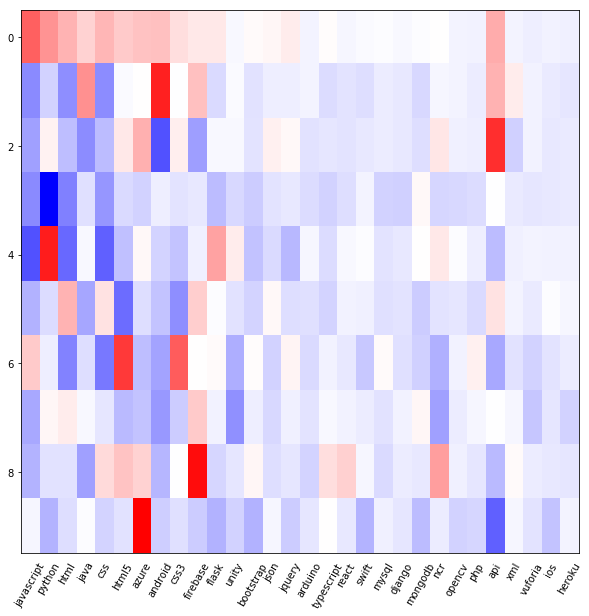

In [130]:
N = 30
ixs_of_interest = []
for tag, _ in tag_counts.most_common(N):
    ixs_of_interest.append(count_vectorizer.vocabulary_[tag])
mat = svd.components_[:, ixs_of_interest]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mat, aspect='auto', cmap='bwr')
ax.set_xticks(range(N))
ax.set_xticklabels([t for t, _ in tag_counts.most_common(N)], rotation=60)
ax.xaxis.set_ticks_position('none')

### 2.3 Clustering Documents

I'll repeat the experiment, using the full `descriptions` instead of just the `tags` columns. 

In [46]:
# vectorize the documents
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
td_count_matrix = count_vectorizer.fit_transform(df['description'])
svd = SVD(10)
svd.fit(td_count_matrix)

data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], count_vectorizer.get_feature_names()), reverse=True)[:10]
    scores, words = zip(*topk)
#     data.append(scores)
    data.append(words)
    
tabulate(data)

0,1,2,3,4,5,6,7,8,9
the,to,and,we,of,in,that,for,it,with
we,to,and,our,it,what,how,as,learned,that
and,to,is,you,my,it,app,this,or,what
to,ingredients,app,that,user,recipes,as,model,recipe,users
of,our,and,model,app,in,recipes,recipe,data,database
our,is,keyboard,that,be,would,could,one,have,keyboards
you,data,that,is,your,model,recipes,keyboard,then,recipe
and,the,we,you,api,will,your,microsoft,app,from
data,for,predict_,app,if,price,is,our,amount,it
in,as,are,with,if,people,predict_,price,you,is


- Those are boring
- Why?
  - Lots of confounding words!
  - Lots of useless co-occurrence data
    - it doesn't help me to know that *the* appears often with *application*

---

    
We can solve this!

Replace our bag of words with a bag of tricks:
- use **tf-idf** instead of basic word counts
- remove useless **stop words**

In [54]:
#I manually created this list so it would be easy to add your own as you experiment 
#In reality you could do something like filter the top N most frequent words (similar to IDF)
stop_words = ['the', 'to', 'we', 'and', 'of', 'it', 'in', 'for', 'with', 'is', 'this', 'my', \
              'that', 'our', 'what', 'on', 'as', 'you', 'was']
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words) # this has lots of parameters - experiment!
# sklearn.feature_extraction.text.TfidfVectorizer?

In [55]:
# vectorize the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])
svd = SVD(10)
svd.fit(tfidf_matrix)
data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], tfidf_vectorizer.get_feature_names()), reverse=True)[:10]
    _, words = zip(*topk)
    data.append(words)
tabulate(data)

0,1,2,3,4,5,6,7,8,9
data,app,application,how,can,an,user,are,be,into
data,stock,analysis,fraud,sentiment,risk,finra,api,machine,python
game,unity,alexa,motion,vr,myo,virtual,reality,leap,stock
alexa,skill,lambda,aws,js,node,bot,jira,voice,learnt
recipe,ingredients,recipes,model,ncr,end,food,items,ingredient,your
chatbot,bot,end,chat,html,candidate,css,microsoft,website,azure
application,notes,stock,will,vision,students,flight,text,android,image
parking,application,park,problem,notes,server,parkme,spots,car,mobile
bot,chatbot,myo,microsoft,unity,parking,ncr,questions,armband,have
food,stock,application,location,eat,campus,drone,maps,google,end


As a final visualization of what's going on, we can take the tags and see what they look like in 2 dimensional space. 


In [23]:
# #stolen from this tutorial: https://colab.research.google.com/notebooks/charts.ipynb
# def enable_plotly_in_cell():
#   import IPython
#   from plotly.offline import init_notebook_mode
#   display(IPython.core.display.HTML('''
#         <script src="/static/components/requirejs/require.js"></script>
#   '''))
#   init_notebook_mode(connected=False)

In [24]:
# import plotly.plotly as py
# import numpy as np
# from plotly.offline import iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# enable_plotly_in_cell()

# tags = [ts.split(',') for ts in df.tags]
# tags = [t for ts in tags for t in ts]
# vocab = list(set(tags))


# v = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words)
# td = v.fit_transform(df['tags'])
# svd = SVD(2)
# svd.fit(td)
# X = svd.transform(v.transform(vocab))
# print(X.shape)
# X = StandardScaler().fit_transform(X)
# iplot([Scatter(x=X[:, 0], y=X[:, 1], text = vocab, mode='markers')])

## 3 Search

- We've shown how to vectorize documents
- 


### 2.4 Extensions

TODO: Fix

At HackGT 5, we will do a more advanced version of this. I'll show you how to make a search engine with these vectors. We'll also talk another, more modern way to represent text as vectors. 

- [latent semantic indexing paper](https://scholar.google.com/citations?user=x8dED5cAAAAJ&hl=en#d=gs_md_cita-d&p=&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3Dx8dED5cAAAAJ%26citation_for_view%3Dx8dED5cAAAAJ%3Au5HHmVD_uO8C%26tzom%3D240)
- [word2vec](https://www.tensorflow.org/tutorials/representation/word2vec)
- [Georgia Tech's Natural Language Processing Course](https://github.com/jacobeisenstein/gt-nlp-class) 

### 3.0 Word Embeddings

In [43]:
documents = [
    "A fruit stand selling fresh produce from local farms.",
    "Sushi prepared with fresh caught fish by our trained chefs.",
    "Burgers and smoked meat, served with fries and your choice of sauces."
]

In [44]:
import torch, torchtext

In [45]:
word2vecin = torchtext.vocab.Vectors('in_pruned.txt', cache = '.')
word2vecout = torchtext.vocab.Vectors('in_pruned.txt', cache = '.')

In [46]:
import nltk
def tokenize(raw_text):
    tokens = []
    for sentence in nltk.sent_tokenize(raw_text):
        tokens += nltk.word_tokenize(sentence)
    tokens = [t.lower() for t in tokens if t.lower() in word2vecin.stoi]
    return tokens


In [1]:
def get_doc_vector(tokens, embedding = word2vecout):
    return sum(embedding[t] / embedding[t].norm() for t in tokens if t not in stop_words) / len(tokens)

def cosine(a, b):
    return a.dot(b) / (a.norm() * b.norm())

def DESM(query, document, embedding = word2vecin):
    query_tokens = tokenize(query)
    doc_tokens = tokenize(document)
    print(query_tokens)
    print(doc_tokens)
    
    if len(doc_tokens) == 0:
        return -np.inf
    
    doc_vector = get_doc_vector(doc_tokens)
    return sum(cosine(word2vecin[t], doc_vector) for t in query_tokens) / len(query_tokens)

def make_query(query, documents, names):
    scores = [DESM(query, document) for document in documents]
    ixs = list(reversed(np.argsort(scores)[-10:]))
    print([names[i] for i in ixs])
    print([scores[i] for i in ixs])

query = "salmon"
make_query(query, documents, ["fruit", "sushi", "meat"])

NameError: name 'word2vecout' is not defined

In [33]:
# def get_doc_vector(tokens):
#     vectors = [word2vecout[token] / word2vecout[token].norm() for token in tokens if token in word2vecout.stoi and token not in stop_words]
#     return sum(vectors) / len(vectors)

# def cosine(a, b):
#     return a.dot(b) / (a.norm() * b.norm())

# def DESM(query, document):
#     doc_tokens = document.split()
#     query_tokens = query.split()
#     if len(doc_tokens) < 10:
#         return -np.inf
#     doc_vector = get_doc_vector(doc_tokens)
#     query_tokens = [t for t in query_tokens if t in word2vecin.stoi]
#     return (sum(cosine(word2vecin[t], doc_vector) for t in query_tokens) / len(query_tokens)).item()
        
# def make_query(query, documents, names):
#     scores = [DESM(query, document) for document in documents]
#     print(scores)
#     print("hello")
#     ixs = np.argsort(scores)[-10:]    
#     print([names[i] for i in reversed(ixs)])
#     print([scores[i] for i in reversed(ixs)])

# query = "whatis "
# make_query(query, documents, ["fruit", "fish", "meat"])

[-inf, 0.5812873840332031, 0.49911919236183167]
hello
['fish', 'meat', 'fruit']
[0.5812873840332031, 0.49911919236183167, -inf]


In [130]:
word2vecin['salmon']

tensor([ 0.0419,  0.1064,  0.1212, -0.0306,  0.1053,  0.0315,  0.1320,
         0.0328, -0.1276, -0.0025,  0.1638,  0.0148,  0.0003, -0.0078,
         0.0894,  0.0404, -0.0762,  0.0452, -0.0116, -0.0590, -0.0883,
        -0.0910,  0.0341, -0.0397, -0.0366, -0.0505,  0.0972,  0.0183,
         0.0293, -0.0099,  0.0584, -0.0567,  0.0748, -0.0880, -0.1134,
         0.0449, -0.0619, -0.0214, -0.0282,  0.0795,  0.0382,  0.0411,
        -0.0004, -0.0801, -0.0411,  0.0684,  0.0186,  0.0735,  0.0398,
         0.1156,  0.0982,  0.0356, -0.0207,  0.1107,  0.0256,  0.0529,
         0.0442,  0.0897, -0.0503, -0.0053, -0.0715,  0.1316, -0.0139,
         0.0396,  0.0643, -0.1387, -0.0148,  0.0430, -0.0735, -0.0263,
        -0.1120,  0.0649, -0.0107, -0.0052, -0.0947, -0.1172,  0.0306,
        -0.0628, -0.0039, -0.1177,  0.0145, -0.0734,  0.0895,  0.0045,
        -0.0259,  0.0733, -0.1502,  0.0480, -0.0199,  0.0146, -0.0689,
        -0.0302, -0.0339, -0.0077, -0.0509,  0.0962, -0.0610, -0.0128,
      